<h1> Titanic - Machine Learning for Disaster </h1> 

In this project the intention is to make a predictive algorithm to predict whether an individual survived or not in the Titanic disaster. The following steps will be followed:

- Cleaning of data
- Drawing statistical insight from data 
- Understanding the important features 
- Applying different predictive algorithms to identify the best predictor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
data_raw = pd.read_csv(r'C:\Users\ASUS\Desktop\Kaggle\Titanic Dataset\train (1).csv')
data_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


As **Pclass** and **SibSp** class are quite hard to interpret, we shall make these into more understandable column headings and replace them.

In [3]:
column_list = data_raw.columns.tolist()
column_list[2] = "Ticket Class"
column_list[6] = "Number of Siblings/Spouses aboard"
column_list[7] = "Number of Parents/Children aboard"
data_raw.columns = column_list
data_raw.head()

,PassengerId,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now we shall find which columns are missing data. The following philosophy will be used to fill missing data:

- The mean of a particular group will be used as a representative figure for a missing piece of data
- If the column has too much missing information in it, it will be removed from the analysis as it provides no valuable insight
- If data is missing in a column such as Age, the mean will be calculated based on groupby() function with respect to gender
- If data is missing in Fare class, the mean will be calculated based on the Ticket class.

Furthermore, data columns such as PassenderId and Ticket will not have any significant impact on the prediction. Hence they will be dropped. Neither is Port of Embarkation expected to have an impact, however this will be further investigated before being dropped. 

In [4]:
data_raw.drop(['PassengerId','Ticket'],axis = 1,inplace = True)


In [5]:
results_raw = data_raw['Survived']

<h3> To avoid leakage of data from test set to training, we need to split the data into Train and Test sets before any missing values and feature engineering is done</h3>

Stratified Splitting will be used to ensure equal ratio of Survival and Death cases in both training and testing sets

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)

for train_index,test_index in split.split(data_raw,results_raw):
    training_data_raw = data_raw.iloc[train_index,:]
    testing_data_raw = data_raw.iloc[test_index,:]
    
    

In [7]:
training_data_raw['Survived'].value_counts(normalize = True).to_frame()

,Survived
0,0.616729
1,0.383271


In [8]:
testing_data_raw['Survived'].value_counts(normalize = True).to_frame()

,Survived
0,0.611111
1,0.388889


**The ratios are equal is both sets of data**

In [9]:
def numberofnan(dataset):
    
    column_labels = dataset.columns.tolist()
    num_missingvalues = list()
    percentage_missingvalues = list()
    for column in column_labels:
        num_missingvalues.append(dataset[column].isna().sum())
        percentage_missingvalues.append(100*(dataset[column].isna().sum())/dataset[column].shape[0])
    missing_value_percentage_df = pd.DataFrame({'Column Name':column_labels,'Number of Missing values':num_missingvalues,'% of missing values':percentage_missingvalues})
    return missing_value_percentage_df

In [10]:
missing_data_df = numberofnan(training_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Survived,0,0
1,Ticket Class,0,0
2,Name,0,0
3,Sex,0,0
4,Age,161,20.0999
5,Number of Siblings/Spouses aboard,0,0
6,Number of Parents/Children aboard,0,0
7,Fare,0,0
8,Cabin,620,77.4032
9,Embarked,2,0.249688


In [11]:
missing_data_df = numberofnan(testing_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Survived,0,0
1,Ticket Class,0,0
2,Name,0,0
3,Sex,0,0
4,Age,16,17.7778
5,Number of Siblings/Spouses aboard,0,0
6,Number of Parents/Children aboard,0,0
7,Fare,0,0
8,Cabin,67,74.4444
9,Embarked,0,0


There is a significant amount of missing values in **Cabin** and **Age**. **Embarked** only lacks 2 values in the **testing_data_raw** set which can be dropped off from the dataset.

In [12]:
training_data_raw.dropna(subset = ['Embarked'],inplace = True)
missing_data_df = numberofnan(training_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Column Name,Number of Missing values,% of missing values
0,Survived,0,0
1,Ticket Class,0,0
2,Name,0,0
3,Sex,0,0
4,Age,161,20.1502
5,Number of Siblings/Spouses aboard,0,0
6,Number of Parents/Children aboard,0,0
7,Fare,0,0
8,Cabin,620,77.597
9,Embarked,0,0


In [13]:
groupeddata = training_data_raw.groupby('Sex')

keylist = list()

for key,group in groupeddata:
    keylist.append(key)

In [14]:
groupeddata.get_group(keylist[0]).head()

,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Cabin,Embarked
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,57.9792,B18,C
496,1,1,"Eustis, Miss. Elizabeth Mussey",female,54.0,1,0,78.2667,D20,C
318,1,1,"Wick, Miss. Mary Natalie",female,31.0,0,2,164.8667,C7,S
649,1,3,"Stanley, Miss. Amy Zillah Elsie",female,23.0,0,0,7.5500,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,NaN,S


In [15]:
groupeddata.get_group(keylist[1]).head()

,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Cabin,Embarked
86,0,3,"Ford, Mr. William Neal",male,16.0,1,3,34.3750,NaN,S
517,0,3,"Ryan, Mr. Patrick",male,NaN,0,0,24.1500,NaN,Q
844,0,3,"Culumovic, Mr. Jeso",male,17.0,0,0,8.6625,NaN,S
408,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,0,0,7.7750,NaN,S
92,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,61.1750,E31,S


In [16]:
#Average Female Age
import math
math.ceil(groupeddata.get_group(keylist[0])['Age'].mean())

28

In [17]:
math.ceil(groupeddata.get_group(keylist[1])['Age'].mean())

31

In [18]:
training_data_raw['Age'] = training_data_raw.groupby('Sex')['Age'].apply(lambda x:x.fillna(math.ceil(x.mean())))
training_data_raw.head(50)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Cabin,Embarked
86,0,3,"Ford, Mr. William Neal",male,16.0,1,3,34.3750,NaN,S
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,57.9792,B18,C
517,0,3,"Ryan, Mr. Patrick",male,31.0,0,0,24.1500,NaN,Q
844,0,3,"Culumovic, Mr. Jeso",male,17.0,0,0,8.6625,NaN,S
408,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,0,0,7.7750,NaN,S
92,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,61.1750,E31,S
625,0,1,"Sutton, Mr. Frederick",male,61.0,0,0,32.3208,D50,S
496,1,1,"Eustis, Miss. Elizabeth Mussey",female,54.0,1,0,78.2667,D20,C
652,0,3,"Kalvik, Mr. Johannes Halvorsen",male,21.0,0,0,8.4333,NaN,S
318,1,1,"Wick, Miss. Mary Natalie",female,31.0,0,2,164.8667,C7,S


In [19]:
missing_data_df = numberofnan(training_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Survived,0,0
1,Ticket Class,0,0
2,Name,0,0
3,Sex,0,0
4,Age,0,0
5,Number of Siblings/Spouses aboard,0,0
6,Number of Parents/Children aboard,0,0
7,Fare,0,0
8,Cabin,620,77.597
9,Embarked,0,0


Due to the very high number of missing values in the **Cabin** column and the lack of any correlation to conclusively fill the missing values, we shall drop this column

In [20]:
#groupedLotFrontageAverages = combinedfeatureset[['LotFrontage','Neighborhood']].groupby(['Neighborhood']).agg(Mean_Lot_Frontage = \
                                                                                                           #  pd.NamedAgg(column = \
                                                                                                        #    'LotFrontage',\
                                                                                                        #    aggfunc = np.mean))

In [21]:
training_data_raw.drop(['Cabin'],axis = 1,inplace = True)
training_data_raw.head()

C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Embarked
86,0,3,"Ford, Mr. William Neal",male,16.0,1,3,34.3750,S
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,57.9792,C
517,0,3,"Ryan, Mr. Patrick",male,31.0,0,0,24.1500,Q
844,0,3,"Culumovic, Mr. Jeso",male,17.0,0,0,8.6625,S
408,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,0,0,7.7750,S


In [22]:
missing_data_df = numberofnan(training_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Survived,0,0
1,Ticket Class,0,0
2,Name,0,0
3,Sex,0,0
4,Age,0,0
5,Number of Siblings/Spouses aboard,0,0
6,Number of Parents/Children aboard,0,0
7,Fare,0,0
8,Embarked,0,0


Lets create a class which can be used in a pipeline to deal with the missing values of the **Age** and **Cabin** attributes so that later we can use it in the pipeline

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class fillmissingvalues(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    def fit(self,dataset):
        return self
    def transform(self,dataset):
        dataset['Age'] = dataset.groupby('Sex')['Age'].apply(lambda x:x.fillna(math.ceil(x.mean())))
        dataset.drop(['Cabin'],axis = 1,inplace = True)
        return dataset

In [24]:
filldrop = fillmissingvalues()
testing_data_raw = filldrop.fit_transform(testing_data_raw)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [25]:
missing_testing_data_df = numberofnan(testing_data_raw)
display(missing_testing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Survived,0,0
1,Ticket Class,0,0
2,Name,0,0
3,Sex,0,0
4,Age,0,0
5,Number of Siblings/Spouses aboard,0,0
6,Number of Parents/Children aboard,0,0
7,Fare,0,0
8,Embarked,0,0


In [26]:
clean_dataset = training_data_raw

<h2> Investigating the effect gender had on the chance of surviving the disaster </h2>

In [27]:
survival_sex = pd.crosstab(clean_dataset['Sex'],clean_dataset['Survived'])
survival_sex

Survived,0,1
Sex,,
female,71,208
male,423,97


In [28]:
survival_sex.index.values.tolist()

['female', 'male']

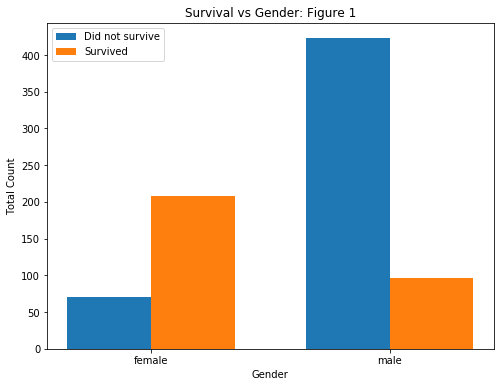

In [29]:
sex = np.arange(len(survival_sex.index.values))
width = 0.35

ax_sex = plt.figure(figsize = (8,6)).add_subplot(111)
ax_sex.bar(sex - width/2,survival_sex[0],width,label = 'Did not survive')
ax_sex.bar(sex + width/2,survival_sex[1],width,label = 'Survived')

ax_sex.set_title('Survival vs Gender: Figure 1')
ax_sex.set_xlabel('Gender')
ax_sex.set_ylabel('Total Count')
ax_sex.set_xticks(sex)
ax_sex.set_xticklabels(survival_sex.index.values.tolist())
ax_sex.legend()

C:\Users\ASUS\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 0.98, 'Survival Probabilty vs Gender: Figure 2')

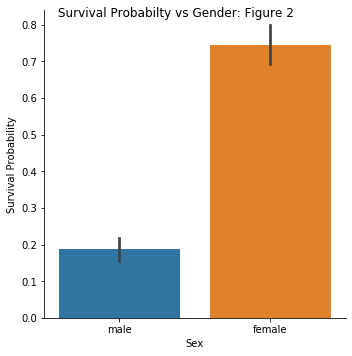

In [30]:
sex_survived = sns.factorplot(x = 'Sex',y = 'Survived',data = clean_dataset, kind = 'bar')
sex_survived.set_ylabels('Survival Probability')
sex_survived.fig.suptitle('Survival Probabilty vs Gender: Figure 2')

<h4>Discussion</h4> 

The results above show that:
- Males had a significant chance of not surviving the disaster. 
- More females survived the disaster than they passed away.

From Figure 2 we see that a male had a very low probability of surviving the disaster

<h4>To investigate the correlation between the gender and the survival rate, we can use the Chi Squared measurement</h4>

In [31]:
contingency_table = survival_sex.transpose().to_numpy()
contingency_table

array([[ 71, 423],
       [208,  97]], dtype=int64)

In [32]:
from scipy.stats import chi2_contingency
chi2val,p,dof,expected = chi2_contingency(contingency_table)

In [33]:
p

1.0571877033634258e-53

In [34]:
chi2val

238.03049798638366

<h2>Investigating the effect Ticket Class had on the chance of surviving the disaster</h2>

In [35]:
survival_ticket = pd.crosstab(clean_dataset['Ticket Class'],clean_dataset['Survived'])
survival_ticket['% Died'] = 100*(survival_ticket[0]/survival_ticket.sum(axis = 1))
survival_ticket['% Survived'] = 100*(survival_ticket[1]/survival_ticket.sum(axis = 1))
survival_ticket

Survived,0,1,% Died,% Survived
Ticket Class,,,,
1,70,120,36.842105,52.900232
2,89,77,53.614458,35.061444
3,335,108,75.620767,20.824465


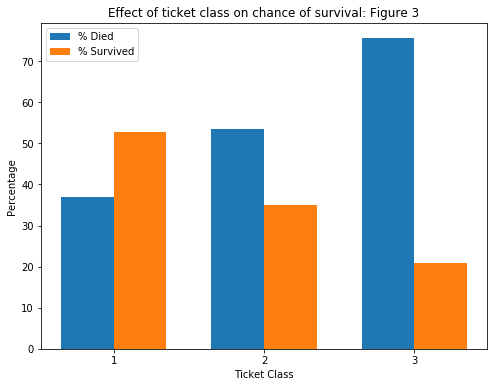

In [36]:
ax_ticketclass = plt.figure(figsize = (8,6)).add_subplot(111)

ticket_classes = np.arange(len(survival_ticket.index.values.tolist()))
width = 0.35

ax_ticketclass.bar(ticket_classes - width/2,survival_ticket['% Died'],width,label = '% Died')
ax_ticketclass.bar(ticket_classes + width/2,survival_ticket['% Survived'],width,label = '% Survived')
ax_ticketclass.set_title('Effect of ticket class on chance of survival: Figure 3')
ax_ticketclass.set_xlabel('Ticket Class')
ax_ticketclass.set_ylabel('Percentage')
ax_ticketclass.set_xticks(ticket_classes)
ax_ticketclass.set_xticklabels(survival_ticket.index.values.tolist())
ax_ticketclass.legend()

Text(0.5, 0.98, 'Survival Probabilty vs Ticket Class: Figure 4')

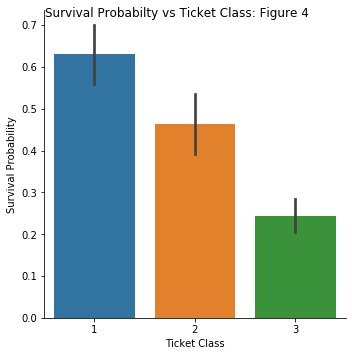

In [37]:
ax_pclass_sns = sns.factorplot(x = 'Ticket Class',y = 'Survived',data = clean_dataset,kind = 'bar')
ax_pclass_sns.set_ylabels('Survival Probability')
ax_pclass_sns.fig.suptitle('Survival Probabilty vs Ticket Class: Figure 4')

Intuitively there is a higher chance that fare and ticket class are correlated. Lets investigate that too

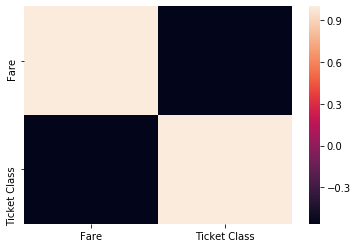

In [38]:
list1 = ['Fare','Ticket Class']
sns.heatmap(clean_dataset[list1].corr())

Intepreting the above heatmap is not straight forward as **Ticket Class** goes from First Class(1) to Third Class(3). Hence lower the ticket class in numerical terms, results in a higher price of the **Fare**. Hence it results in a strong negative correlation showing that Fare increases as Ticket Class goes from Third Class to First Class.

From the above analysis, we can say that paying a higher Fare for a ticket of a higher class had a higher chance of survival.

<h3> Investigating how Fare effected the chance of survival </h3>

Text(0.5, 1.0, 'Fare vs Survival: Figure 5')

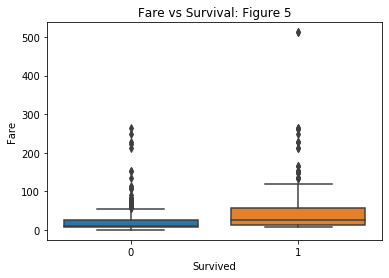

In [39]:
fare_grid = sns.boxplot(x = 'Survived',y = 'Fare',data = clean_dataset)
fare_grid.set_title('Fare vs Survival: Figure 5')

The above box plot in figure 5 shows that the Average Fare of an individual who survived is higher. Furthermore the 25th to 75th percentiles are much larger for the individuals who survived, with the 75th percentile and the Maximum (75th Percentile + 1.5* Interquartile Range) being much higher for the individuals that survived.

<h4>Discussion</h4>
An individual of the lower ticket class(3), had a lesser chance of surviving the disaster as compared to the an individual in the First Class. An individual in the second class however has an equal chance of both surviving and dying in the disaster. The First Class ticket holders have clearly been given priority in being saved. 


**Fare and Ticket Class can be used as features for prediction**

<h3> Extended Analysis </h3>

Earlier it was seen that more males died in the disaster. BUT did a first class ticket holder who was a male have a higher chance of surviving the disaster as compared to a male with a third class ticket?

In [40]:
extended_analysis_one = clean_dataset.loc[(clean_dataset['Sex'] == 'male') & ((clean_dataset['Ticket Class'].astype(int) == 1) | (clean_dataset['Ticket Class'].astype(int) == 2) | (clean_dataset['Ticket Class'].astype(int) == 3))]

In [41]:
extended_analysis_one_temp = pd.crosstab(extended_analysis_one['Ticket Class'],extended_analysis_one['Survived'])
extended_analysis_one_temp['% Died'] = 100*(extended_analysis_one_temp[0]/extended_analysis_one_temp.sum(axis = 1))
extended_analysis_one_temp['% Survived'] = 100*(extended_analysis_one_temp[1]/extended_analysis_one_temp.sum(axis = 1))
extended_analysis_one_temp

Survived,0,1,% Died,% Survived
Ticket Class,,,,
1,68,37,64.761905,21.795231
2,84,16,84.000000,8.695652
3,271,44,86.031746,10.971700


C:\Users\ASUS\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 0.98, 'Survival Probabilty vs Ticket Class(Males): Figure 6')

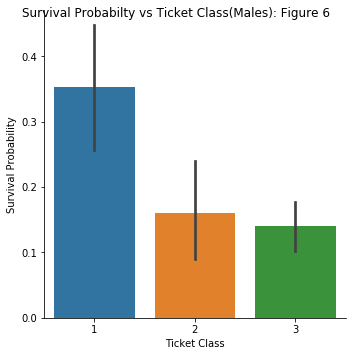

In [42]:
sns_male_extended = sns.factorplot(x = 'Ticket Class', y = 'Survived', data = extended_analysis_one, kind = 'bar')
sns_male_extended.set_ylabels('Survival Probability')
sns_male_extended.fig.suptitle('Survival Probabilty vs Ticket Class(Males): Figure 6')

Males in First Class also had higher death counts as compared to women, however a male in first class had a higher chance of surviving as compared to a male in Third Class

<h1>Investigating how having siblings/spouses affected chances of survival</h1>

In [43]:
survival_siblingsspouses = pd.crosstab(clean_dataset['Number of Siblings/Spouses aboard'],clean_dataset['Survived'])
survival_siblingsspouses

Survived,0,1
Number of Siblings/Spouses aboard,,
0,360,187
1,86,100
2,13,12
3,10,3
4,14,3
5,5,0
8,6,0


Text(0.5, 0.98, 'Survival Probabilty vs Number of Siblings/Spouse: Figure 7')

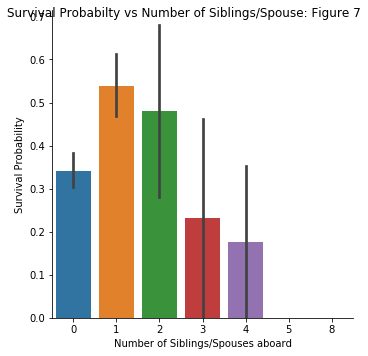

In [44]:
sns_siblings = sns.factorplot(x = 'Number of Siblings/Spouses aboard', y = 'Survived', data = clean_dataset, kind = 'bar')
sns_siblings.set_ylabels('Survival Probability')
sns_siblings.fig.suptitle('Survival Probabilty vs Number of Siblings/Spouse: Figure 7')

As shown by the above Table and Figure 7 show that **ideally you want only 1 sibling or spouse with you**. Having a higher number of siblings or a spouse than 1 decreases your chance of survival. 

Having 0 siblings and spouse resulted in lower chance of survival because you had no one to help you survive the disaster. 

<h1>Investigating how having children/parents affected chances of survival</h1>

In [45]:
survival_childrenparents = pd.crosstab(clean_dataset['Number of Parents/Children aboard'],clean_dataset['Survived'])
survival_childrenparents

Survived,0,1
Number of Parents/Children aboard,,
0,400,204
1,49,57
2,34,40
3,2,3
4,4,0
5,4,1
6,1,0


Text(0.5, 0.98, 'Survival Probabilty vs Number of Parents/Children aboard: Figure 8')

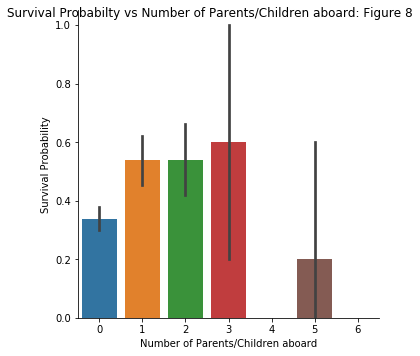

In [46]:
sns_chilpar = sns.factorplot(x = 'Number of Parents/Children aboard', y = 'Survived', data = clean_dataset, kind = 'bar')
sns_chilpar.set_ylabels('Survival Probability')
sns_chilpar.fig.suptitle('Survival Probabilty vs Number of Parents/Children aboard: Figure 8')

It seems that having a larger family results in decreased chance of survival. To make this factor more impactful on the prediction of survival, we can create a new attribute called **Family Size**

**Family Size = Number of Siblings/Spouses aboard + Number of Parents/Children aboard + 1**(1 is for the passenger themselves)

In [47]:
clean_dataset['Family Size'] = clean_dataset['Number of Siblings/Spouses aboard'] + clean_dataset['Number of Parents/Children aboard'] + 1

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
clean_dataset.head()

,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Embarked,Family Size
86,0,3,"Ford, Mr. William Neal",male,16.0,1,3,34.3750,S,5
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,57.9792,C,2
517,0,3,"Ryan, Mr. Patrick",male,31.0,0,0,24.1500,Q,1
844,0,3,"Culumovic, Mr. Jeso",male,17.0,0,0,8.6625,S,1
408,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,0,0,7.7750,S,1


Creating a class to create the new **Family Size** dataset

In [49]:
from sklearn.base import BaseEstimator,TransformerMixin

class createfamilysize(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    def fit(self,dataset):
        return self
    def transform(self,dataset):
        dataset['Family Size'] = dataset['Number of Siblings/Spouses aboard'] + dataset['Number of Parents/Children aboard'] + 1
        dataset.drop(['Number of Siblings/Spouses aboard','Number of Parents/Children aboard'],axis = 1,inplace = True)
        return dataset


<h1>Effect of Family Size on chance of survival</h1>

Text(0.5, 0.98, 'Family Size vs Survival Probability:Figure 9')

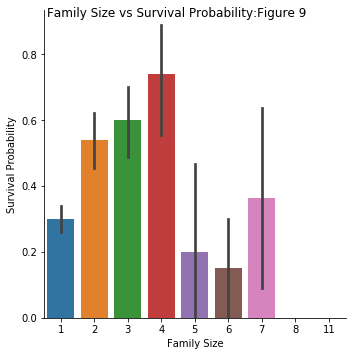

In [50]:
sns_familysize = sns.factorplot(x = 'Family Size', y = 'Survived', data = clean_dataset, kind = 'bar')
sns_familysize.set_ylabels('Survival Probability')
sns_familysize.fig.suptitle('Family Size vs Survival Probability:Figure 9')

From Figure 9 we see that having a **family of 2,3 or 4 members** increases your chances of surviving. Hence this will be the useful feature to use instead of the **Sibling/Spouse** and **Parent/Children** features.



In [51]:
clean_dataset = clean_dataset.drop(['Number of Siblings/Spouses aboard','Number of Parents/Children aboard'],axis = 1)
clean_dataset


,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size
86,0,3,"Ford, Mr. William Neal",male,16.0,34.3750,S,5
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,57.9792,C,2
517,0,3,"Ryan, Mr. Patrick",male,31.0,24.1500,Q,1
844,0,3,"Culumovic, Mr. Jeso",male,17.0,8.6625,S,1
408,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,7.7750,S,1
92,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,61.1750,S,2
625,0,1,"Sutton, Mr. Frederick",male,61.0,32.3208,S,1
496,1,1,"Eustis, Miss. Elizabeth Mussey",female,54.0,78.2667,C,2
652,0,3,"Kalvik, Mr. Johannes Halvorsen",male,21.0,8.4333,S,1
318,1,1,"Wick, Miss. Mary Natalie",female,31.0,164.8667,S,3


In [52]:
famsize = createfamilysize()
testing_data_raw = famsize.fit_transform(testing_data_raw)
testing_data_raw.head()

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size
530,1,2,"Quick, Miss. Phyllis May",female,2.0,26.000,S,3
401,0,3,"Adams, Mr. John",male,26.0,8.050,S,1
433,0,3,"Kallio, Mr. Nikolai Erland",male,17.0,7.125,S,1
241,1,3,"Murphy, Miss. Katherine ""Kate""",female,27.0,15.500,Q,2
773,0,3,"Elias, Mr. Dibo",male,33.0,7.225,C,1


<h1> Investigating how age impacts the chance of survival </h1>

We shall use a box plot to visualize the average age of the ones who survived and died

Text(0.5, 1.0, 'Boxplot of Age vs Survival:Figure 10')

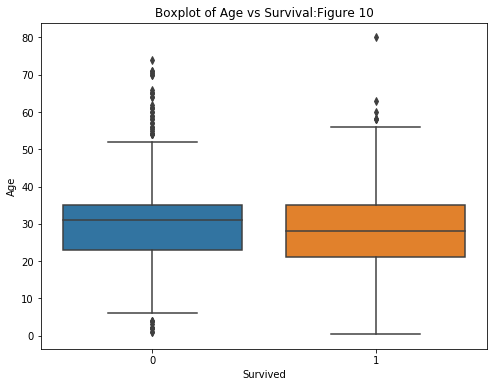

In [53]:
ax = plt.figure(figsize = (8,6)).add_subplot(111)

sns.boxplot(x = 'Survived', y = 'Age',data = clean_dataset,ax = ax)
ax.set_title('Boxplot of Age vs Survival:Figure 10')

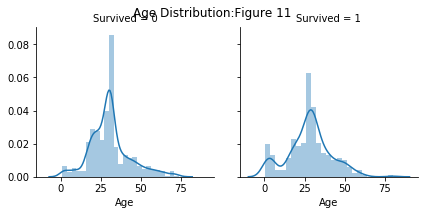

In [54]:
age_grid = sns.FacetGrid(clean_dataset,col = 'Survived')
age_grid.map(sns.distplot,'Age',bins = 25)
age_grid.fig.suptitle('Age Distribution:Figure 11')
age_grid.fig.subplots_adjust(hspace=0.9, wspace=.15)
plt.show()

- From Figure 10 and Figure 11, we see that Children below 10 had a higher chance of surviving
- Age group of 20-30 had lower chance of surviving as per Figure 11

We can create new age groups from the above observations:

- 0 to 12 years (Child)
- 13 to 18 years (Adolescence)
- 19 - 30 years(Young Adult)
- 30 - 60 years(Adult)
- 60 + (Senior)

In [55]:

def splitagegroups(dataset):
    dataset.loc[(dataset['Age']>=0) & (dataset['Age']<12), 'Age Group'] = 'Child'
    dataset.loc[(dataset['Age']>=12) & (dataset['Age']<18), 'Age Group'] = 'Adolescence'
    dataset.loc[(dataset['Age']>=18) & (dataset['Age']<50), 'Age Group'] = 'Adult'
    dataset.loc[(dataset['Age']>=50) & (dataset['Age']<60), 'Age Group'] = 'Early Senior'
    dataset.loc[(dataset['Age']>=60), 'Age Group'] = 'Senior'
    return dataset

In [56]:
clean_dataset = splitagegroups(clean_dataset)
clean_dataset.head()

,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,Age Group
86,0,3,"Ford, Mr. William Neal",male,16.0,34.3750,S,5,Adolescence
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,57.9792,C,2,Adolescence
517,0,3,"Ryan, Mr. Patrick",male,31.0,24.1500,Q,1,Adult
844,0,3,"Culumovic, Mr. Jeso",male,17.0,8.6625,S,1,Adolescence
408,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,7.7750,S,1,Adult


In [57]:
testing_data_raw = splitagegroups(testing_data_raw)
testing_data_raw.head()

C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,Age Group
530,1,2,"Quick, Miss. Phyllis May",female,2.0,26.000,S,3,Child
401,0,3,"Adams, Mr. John",male,26.0,8.050,S,1,Adult
433,0,3,"Kallio, Mr. Nikolai Erland",male,17.0,7.125,S,1,Adolescence
241,1,3,"Murphy, Miss. Katherine ""Kate""",female,27.0,15.500,Q,2,Adult
773,0,3,"Elias, Mr. Dibo",male,33.0,7.225,C,1,Adult


In [58]:
age_group_crosstab = pd.crosstab(clean_dataset['Age Group'],clean_dataset['Survived'])
age_group_crosstab

Survived,0,1
Age Group,,
Adolescence,20,18
Adult,403,230
Child,26,37
Early Senior,27,17
Senior,18,3


C:\Users\ASUS\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 0.98, 'Age Group vs Survival:Figure 12')

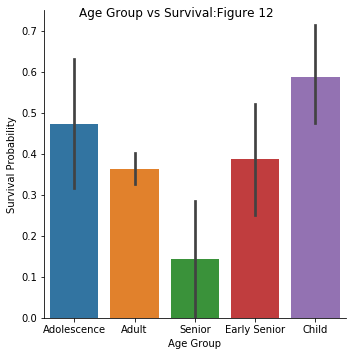

In [59]:
sns_age_group = sns.factorplot(x = 'Age Group',y = 'Survived',data = clean_dataset, kind = 'bar')
sns_age_group.set_ylabels('Survival Probability')
sns_age_group.fig.suptitle('Age Group vs Survival:Figure 12')

Adults and Seniors had the lowest chance of surviving the disaster

<h1> Investigating how Port of Embarkation affected survival </h1>

Text(0.5, 0.98, 'Embarking Port vs Survival:Figure 13')

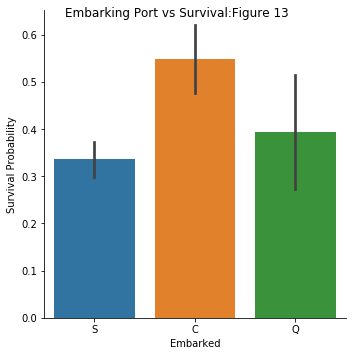

In [60]:
sns_embarking_port = sns.factorplot(x = 'Embarked',y = 'Survived',data = clean_dataset, kind = 'bar')
sns_embarking_port.set_ylabels('Survival Probability')
sns_embarking_port.fig.suptitle('Embarking Port vs Survival:Figure 13')

In [61]:
port_crosstab = pd.crosstab(clean_dataset['Embarked'],clean_dataset['Survived'])
port_crosstab

Survived,0,1
Embarked,,
C,69,84
Q,40,26
S,385,195


What makes Embarkation Port C increase chances of survival?

In [62]:
df_embarking = clean_dataset.loc[clean_dataset['Embarked'] == 'C']
df_embarking.head(168)

,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,Age Group
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.00,57.9792,C,2,Adolescence
496,1,1,"Eustis, Miss. Elizabeth Mussey",female,54.00,78.2667,C,2,Early Senior
122,0,2,"Nasser, Mr. Nicholas",male,32.50,30.0708,C,2,Adult
393,1,1,"Newell, Miss. Marjorie",female,23.00,113.2750,C,2,Adult
604,1,1,"Homer, Mr. Harry (""Mr E Haven"")",male,35.00,26.5500,C,1,Adult
34,0,1,"Meyer, Mr. Edgar Joseph",male,28.00,82.1708,C,2,Adult
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,30.0708,C,2,Adolescence
487,0,1,"Kent, Mr. Edward Austin",male,58.00,29.7000,C,1,Early Senior
155,0,1,"Williams, Mr. Charles Duane",male,51.00,61.3792,C,2,Early Senior
858,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.00,19.2583,C,4,Adult


Looking at the dataset itself, it seems that the family size of the individuals who embarked from port C have family sizes which are ideal for survival. Lets investigate this further

In [63]:
df_embarking['Ticket Class'].value_counts().to_frame()

,Ticket Class
1,77
3,62
2,14


In [64]:
df_embarking['Family Size'].value_counts().to_frame()

,Family Size
1,77
2,47
3,20
4,7
5,2


From the above analysis, it seems that majority of passengers from port C were of First Class. This clearly increases their chances of survival as we saw in Figure 4. 

Text(0.5, 0.98, 'Embarking Port C/Ticket Class vs Survival:Figure 14')

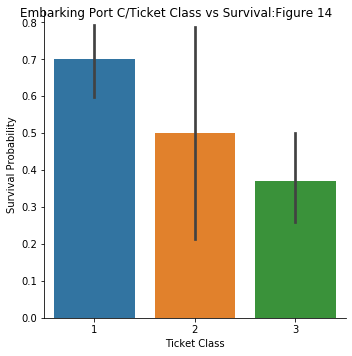

In [65]:
ticket_class_portc = sns.factorplot(x = 'Ticket Class',y = 'Survived', data = df_embarking, kind = 'bar')
ticket_class_portc.set_ylabels('Survival Probability')
ticket_class_portc.fig.suptitle('Embarking Port C/Ticket Class vs Survival:Figure 14')

In [66]:
#how many first class passengers from port C survived
pd.crosstab(df_embarking['Ticket Class'],df_embarking['Survived'])

Survived,0,1
Ticket Class,,
1,23,54
2,7,7
3,39,23


In [67]:
df_embarking_c_firstclass = df_embarking.loc[df_embarking['Ticket Class'] == 1]
pd.crosstab(df_embarking_c_firstclass['Family Size'],df_embarking_c_firstclass['Survived'])

Survived,0,1
Family Size,,
1,14,24
2,7,23
3,2,5
5,0,2


Text(0.5, 0.98, 'Embarking Port C/First Class/Family Size vs Survival:Figure 15')

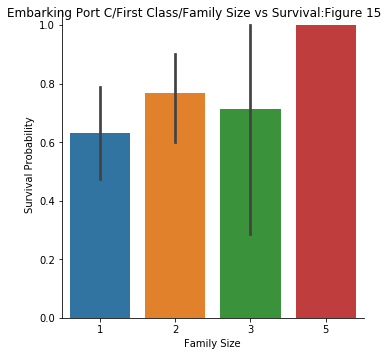

In [68]:
ticket_class_portc_firstclass = sns.factorplot(x = 'Family Size',y = 'Survived', data = df_embarking_c_firstclass, kind = 'bar')
ticket_class_portc_firstclass.set_ylabels('Survival Probability')
ticket_class_portc_firstclass.fig.suptitle('Embarking Port C/First Class/Family Size vs Survival:Figure 15')

Port C contains a lot of passengers from First Class and also with a family size which increases chance of survival as proven earlier in Figures 4 and 9.

Individuals of **First Class** with a **family size of 2**, embarking from **Port C** have a very high chance of surviving the disaster. Hence we can create a feature targetting this group of individuals. While **family size of 1,3,5** do have more survivers in each group, they either have equally high deaths(**Family size:1,3**) OR too few instances(**Family size:5**)

In [69]:
clean_dataset['PortC_Advantage'] = np.zeros(clean_dataset.shape[0])
clean_dataset.loc[(clean_dataset['Ticket Class'] == 1) & (clean_dataset['Family Size'] == 2), 'PortC_Advantage'] = 1

In [70]:
clean_dataset['PortC_Advantage'] = clean_dataset['PortC_Advantage'].astype(int)
clean_dataset.head()

,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,Age Group,PortC_Advantage
86,0,3,"Ford, Mr. William Neal",male,16.0,34.3750,S,5,Adolescence,0
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,57.9792,C,2,Adolescence,1
517,0,3,"Ryan, Mr. Patrick",male,31.0,24.1500,Q,1,Adult,0
844,0,3,"Culumovic, Mr. Jeso",male,17.0,8.6625,S,1,Adolescence,0
408,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,7.7750,S,1,Adult,0


<h5>Class for creating PortC_Advantage</h5>

In [71]:
from sklearn.base import BaseEstimator,TransformerMixin

class createportCadvantage(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    def fit(self,dataset):
        return self
    def transform(self,dataset):
        dataset['PortC_Advantage'] = np.zeros(dataset.shape[0])
        dataset.loc[(dataset['Ticket Class'] == 1) & (dataset['Family Size'] == 2), 'PortC_Advantage'] = 1
        dataset['PortC_Advantage'] = dataset['PortC_Advantage'].astype(int)
        return dataset

In [72]:
portCadvantage = createportCadvantage()
testing_data_raw = portCadvantage.fit_transform(testing_data_raw)
testing_data_raw.head()

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,Age Group,PortC_Advantage
530,1,2,"Quick, Miss. Phyllis May",female,2.0,26.000,S,3,Child,0
401,0,3,"Adams, Mr. John",male,26.0,8.050,S,1,Adult,0
433,0,3,"Kallio, Mr. Nikolai Erland",male,17.0,7.125,S,1,Adolescence,0
241,1,3,"Murphy, Miss. Katherine ""Kate""",female,27.0,15.500,Q,2,Adult,0
773,0,3,"Elias, Mr. Dibo",male,33.0,7.225,C,1,Adult,0


In [73]:
clean_dataset['Title'] = [name.split(',')[1].split('.')[0].strip() for name in clean_dataset['Name'].tolist()]
clean_dataset.head()

,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,Age Group,PortC_Advantage,Title
86,0,3,"Ford, Mr. William Neal",male,16.0,34.3750,S,5,Adolescence,0,Mr
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,57.9792,C,2,Adolescence,1,Miss
517,0,3,"Ryan, Mr. Patrick",male,31.0,24.1500,Q,1,Adult,0,Mr
844,0,3,"Culumovic, Mr. Jeso",male,17.0,8.6625,S,1,Adolescence,0,Mr
408,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,7.7750,S,1,Adult,0,Mr


<h5>Class for creating Title</h5>



In [74]:
from sklearn.base import BaseEstimator,TransformerMixin

class createTitle(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    def fit(self,dataset):
        return self
    def transform(self,dataset):
        dataset['Title'] = [name.split(',')[1].split('.')[0].strip() for name in dataset['Name'].tolist()]
        return dataset

In [75]:
title = createTitle()
testing_data_raw = title.fit_transform(testing_data_raw)
testing_data_raw.head()

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,Age Group,PortC_Advantage,Title
530,1,2,"Quick, Miss. Phyllis May",female,2.0,26.000,S,3,Child,0,Miss
401,0,3,"Adams, Mr. John",male,26.0,8.050,S,1,Adult,0,Mr
433,0,3,"Kallio, Mr. Nikolai Erland",male,17.0,7.125,S,1,Adolescence,0,Mr
241,1,3,"Murphy, Miss. Katherine ""Kate""",female,27.0,15.500,Q,2,Adult,0,Miss
773,0,3,"Elias, Mr. Dibo",male,33.0,7.225,C,1,Adult,0,Mr


<h1> Investigating the affect of Title on chance of survival </h1>

In [76]:
title_crosstab = pd.crosstab(clean_dataset['Title'],clean_dataset['Survived'])
title_crosstab

Survived,0,1
Title,,
Capt,1,0
Col,1,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,0,1
Master,17,22
Miss,47,112


Text(0.5, 0.98, 'Title vs Survival Probability:Figure 16')

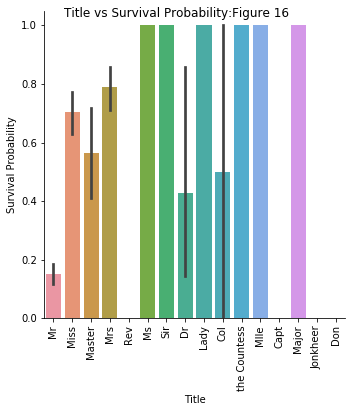

In [77]:
sns_title = sns.factorplot(x = 'Title', y = 'Survived',data = clean_dataset,kind = 'bar')
sns_title.set_ylabels('Survival Probability')
sns_title.set_xticklabels(rotation = 90)
sns_title.fig.suptitle('Title vs Survival Probability:Figure 16')

In [78]:
#were all noblemen and noblewomen of first class?
clean_dataset.loc[(clean_dataset['Title'] == 'the Countess')|(clean_dataset['Title'] == 'Mme')|(clean_dataset['Title'] == 'Mlle')\
                 |(clean_dataset['Title'] == 'Sir')|(clean_dataset['Title'] == 'Lady')]

,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,Age Group,PortC_Advantage,Title
599,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,56.9292,C,2,Adult,1,Sir
556,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,39.6000,C,2,Adult,1,Lady
759,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,86.5000,S,1,Adult,0,the Countess
710,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,49.5042,C,1,Adult,0,Mlle
641,1,1,"Sagesser, Mlle. Emma",female,24.0,69.3000,C,1,Adult,0,Mlle


All Noblemen and Noblewomen survived and were having First Class tickets

From the above analysis the following titles have very low chance of surviving:
    
    - Rev
    - Mr

The following titles have high chance of surviving:
    - Miss
    - Mrs

There are a few Nobleman and Noblewomen too who have all survived. They had higher priority and were presumably of first class. Hence they too have high chace of surviving:
 
     - the Countess
     - Mme
     - Mlle
     - Sir
     - Lady
 
The instances of the other categories were either:
- Too low to give a definite judgement, hence their chance of survival is unknown. 
- Mixed between having survived or died to make a conclusive decision about the advantage the title brings
 
Hence we can create a new feature called "Title Advantage"

In [79]:
clean_dataset['Title Advantage'] = ['Inconclusive']*(clean_dataset.shape[0])

clean_dataset.loc[(clean_dataset['Title'] == 'Rev') | (clean_dataset['Title'] == 'Mr'),'Title Advantage'] = 'Low'
clean_dataset.loc[(clean_dataset['Title'] == 'Miss') | (clean_dataset['Title'] == 'Mrs'),'Title Advantage'] = 'High'
clean_dataset.loc[(clean_dataset['Title'] == 'the Countess') | (clean_dataset['Title'] == 'Mme')|(clean_dataset['Title'] == 'Mlle')|(clean_dataset['Title'] == 'Sir')|(clean_dataset['Title'] == 'Lady'),'Title Advantage'] = 'High'

In [80]:
clean_dataset.head()

,Survived,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,Age Group,PortC_Advantage,Title,Title Advantage
86,0,3,"Ford, Mr. William Neal",male,16.0,34.3750,S,5,Adolescence,0,Mr,Low
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,57.9792,C,2,Adolescence,1,Miss,High
517,0,3,"Ryan, Mr. Patrick",male,31.0,24.1500,Q,1,Adult,0,Mr,Low
844,0,3,"Culumovic, Mr. Jeso",male,17.0,8.6625,S,1,Adolescence,0,Mr,Low
408,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,7.7750,S,1,Adult,0,Mr,Low


**Name**,**Title** and **Title Advantage** are features interlinked with each other, hence **Name** and **Title** will be dropped from the dataset.

In [81]:
clean_dataset.drop(['Name','Title'],axis = 1,inplace = True)
clean_dataset.head()

,Survived,Ticket Class,Sex,Age,Fare,Embarked,Family Size,Age Group,PortC_Advantage,Title Advantage
86,0,3,male,16.0,34.3750,S,5,Adolescence,0,Low
329,1,1,female,16.0,57.9792,C,2,Adolescence,1,High
517,0,3,male,31.0,24.1500,Q,1,Adult,0,Low
844,0,3,male,17.0,8.6625,S,1,Adolescence,0,Low
408,0,3,male,21.0,7.7750,S,1,Adult,0,Low


<h5>Create class to make **Title Advantage** and drop **Name and Title**

In [82]:
from sklearn.base import BaseEstimator,TransformerMixin

class createTitleAdvantage(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    def fit(self,dataset):
        return self
    def transform(self,dataset):
        dataset['Title Advantage'] = ['Inconclusive']*(dataset.shape[0])
        dataset.loc[(dataset['Title'] == 'Rev') | (dataset['Title'] == 'Mr'),'Title Advantage'] = 'Low'
        dataset.loc[(dataset['Title'] == 'Miss') | (dataset['Title'] == 'Mrs'),'Title Advantage'] = 'High'
        dataset.loc[(dataset['Title'] == 'the Countess') | (dataset['Title'] == 'Mme')|(dataset['Title'] == 'Mlle')|(dataset['Title'] == 'Sir')|(dataset['Title'] == 'Lady'),'Title Advantage'] = 'High'
        dataset.drop(['Name','Title'],axis = 1,inplace = True)
        return dataset


In [83]:
titleadvantage = createTitleAdvantage()
testing_data_raw = titleadvantage.fit_transform(testing_data_raw)
testing_data_raw.head()

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Survived,Ticket Class,Sex,Age,Fare,Embarked,Family Size,Age Group,PortC_Advantage,Title Advantage
530,1,2,female,2.0,26.000,S,3,Child,0,High
401,0,3,male,26.0,8.050,S,1,Adult,0,Low
433,0,3,male,17.0,7.125,S,1,Adolescence,0,Low
241,1,3,female,27.0,15.500,Q,2,Adult,0,High
773,0,3,male,33.0,7.225,C,1,Adult,0,Low


The numerical attribute of **Age** is a more comprehensive feature to work with, hence **Age Group** will be dropped. 

In [84]:
clean_dataset.drop(['Age Group'],axis = 1, inplace = True)
clean_dataset.head()

,Survived,Ticket Class,Sex,Age,Fare,Embarked,Family Size,PortC_Advantage,Title Advantage
86,0,3,male,16.0,34.3750,S,5,0,Low
329,1,1,female,16.0,57.9792,C,2,1,High
517,0,3,male,31.0,24.1500,Q,1,0,Low
844,0,3,male,17.0,8.6625,S,1,0,Low
408,0,3,male,21.0,7.7750,S,1,0,Low


In [85]:
testing_data_raw.drop(['Age Group'],axis = 1, inplace = True)
testing_data_raw.head()

,Survived,Ticket Class,Sex,Age,Fare,Embarked,Family Size,PortC_Advantage,Title Advantage
530,1,2,female,2.0,26.000,S,3,0,High
401,0,3,male,26.0,8.050,S,1,0,Low
433,0,3,male,17.0,7.125,S,1,0,Low
241,1,3,female,27.0,15.500,Q,2,0,High
773,0,3,male,33.0,7.225,C,1,0,Low


<h2>Data Preparation and Exploratory Data Analysis is completed</h2>

2 data sets have been created in parallel for training and testing(**clean_dataset** and **testing_data_raw**). The insights obtained from the training dataset(**clean_dataset**) were made into classes and applied **INDEPENDENTLY** to the **testing_data** through the use of Classes. 

Insights we got:

- Females have a higher chance of surviving the disaster
- Family size of 2,3,4 greatly increase your chances of survival
- If you embarked from Port C with a First Class Ticket, you had a better chance of surviving
- Overall Port C Passengers had a higher chance of surviving
- Higher the Ticket Fare, greater your chances of surviving
- Certain Titles(Miss,Mrs,Mme,Mlle,the Countess, Sir, Lady) increased your chances of survival while certain titles(Mr,Rev) decreased your chances of survival. Other cases were marked inconclusive


<h1>Building the Machine Learning Pipeline</h1>

<h1> Models to be evaluated </h1>

- Logistic Regression with Lasso regularization
- SVM
- Random Forest
- Decision Tree

<h3> Build a classes to seperate the numerical and categorical attributes </h3>

In [86]:
num_attributes = ['Age','Fare','Family Size']
cat_attributes = ['Ticket Class','Sex','Embarked','PortC_Advantage','Title Advantage']

In [87]:
#Build a class to separate the numerical attributes and categorical attributes
#returns dataframes
from sklearn.base import BaseEstimator, TransformerMixin
class AttributeSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attributes):
        
        self.attributes = attributes
    def fit(self,X,y = None):
        return self
    def transform(self,X):
        return X[self.attributes]

In [88]:
class onehotencodedataframe(BaseEstimator,TransformerMixin):
    def __init__(self,attributes):
        self.attributes = attributes
    def fit(self,X):
        return self
    def transform(self,X):
        for attrib in self.attributes:
            X = pd.get_dummies(X,columns = [attrib])
        return X

In [89]:
class scalerdataframe(BaseEstimator,TransformerMixin):
    def __init__(self):
        #,indexvalues,columnvalues
        #self.index = indexvalues
        #self.columnnames = columnvalues
        return None
    def fit(self,data):
        return self
    def transform(self,dataset):
        scl = StandardScaler()
        scaleddf = pd.DataFrame(scl.fit_transform(dataset.values),index = dataset.index,columns = dataset.columns)
        return scaleddf

In [90]:
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
    ('num_selector',AttributeSelector(num_attributes)),
    ('scl_df',scalerdataframe()),
])

In [91]:
cat_pipeline = Pipeline([
    ('cat_selector',AttributeSelector(cat_attributes)),
    ('onehotdf',onehotencodedataframe(cat_attributes)),
])

In [94]:
from sklearn.preprocessing import StandardScaler

In [95]:
numerical_df = num_pipeline.fit_transform(clean_dataset)
categorical_df = cat_pipeline.fit_transform(clean_dataset)

In [96]:
numerical_df.head()

,Age,Fare,Family Size
86,-1.050370,0.053960,1.899774
329,-1.050370,0.549382,0.051658
517,0.100735,-0.160649,-0.564381
844,-0.973630,-0.485712,-0.564381
408,-0.666668,-0.504340,-0.564381


In [97]:
categorical_df.head()

,Ticket Class_1,Ticket Class_2,Ticket Class_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,PortC_Advantage_0,PortC_Advantage_1,Title Advantage_High,Title Advantage_Inconclusive,Title Advantage_Low
86,0,0,1,0,1,0,0,1,1,0,0,0,1
329,1,0,0,1,0,1,0,0,0,1,1,0,0
517,0,0,1,0,1,0,1,0,1,0,0,0,1
844,0,0,1,0,1,0,0,1,1,0,0,0,1
408,0,0,1,0,1,0,0,1,1,0,0,0,1


In [98]:
final_df_training = pd.concat([numerical_df,categorical_df],axis =1 )
final_df_training.head()

,Age,Fare,Family Size,Ticket Class_1,Ticket Class_2,Ticket Class_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,PortC_Advantage_0,PortC_Advantage_1,Title Advantage_High,Title Advantage_Inconclusive,Title Advantage_Low
86,-1.050370,0.053960,1.899774,0,0,1,0,1,0,0,1,1,0,0,0,1
329,-1.050370,0.549382,0.051658,1,0,0,1,0,1,0,0,0,1,1,0,0
517,0.100735,-0.160649,-0.564381,0,0,1,0,1,0,1,0,1,0,0,0,1
844,-0.973630,-0.485712,-0.564381,0,0,1,0,1,0,0,1,1,0,0,0,1
408,-0.666668,-0.504340,-0.564381,0,0,1,0,1,0,0,1,1,0,0,0,1


In [99]:
y_labels_training = clean_dataset[['Survived']]
y_labels_training.head()

,Survived
86,0
329,1
517,0
844,0
408,0


In [115]:
numerical_df_testing = num_pipeline.fit_transform(testing_data_raw)
categorical_df_testing = cat_pipeline.fit_transform(testing_data_raw)

In [116]:
numerical_df_testing.head()

,Age,Fare,Family Size
530,-2.259514,-0.134013,0.772591
401,-0.343318,-0.410694,-0.539356
433,-1.061892,-0.424952,-0.539356
241,-0.263477,-0.295860,0.116618
773,0.215572,-0.423410,-0.539356


In [117]:
categorical_df_testing.head()

,Ticket Class_1,Ticket Class_2,Ticket Class_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,PortC_Advantage_0,PortC_Advantage_1,Title Advantage_High,Title Advantage_Inconclusive,Title Advantage_Low
530,0,1,0,1,0,0,0,1,1,0,1,0,0
401,0,0,1,0,1,0,0,1,1,0,0,0,1
433,0,0,1,0,1,0,0,1,1,0,0,0,1
241,0,0,1,1,0,0,1,0,1,0,1,0,0
773,0,0,1,0,1,1,0,0,1,0,0,0,1


In [119]:
final_df_testing = pd.concat([numerical_df_testing,categorical_df_testing],axis =1 )
final_df_testing.head()

,Age,Fare,Family Size,Ticket Class_1,Ticket Class_2,Ticket Class_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,PortC_Advantage_0,PortC_Advantage_1,Title Advantage_High,Title Advantage_Inconclusive,Title Advantage_Low
530,-2.259514,-0.134013,0.772591,0,1,0,1,0,0,0,1,1,0,1,0,0
401,-0.343318,-0.410694,-0.539356,0,0,1,0,1,0,0,1,1,0,0,0,1
433,-1.061892,-0.424952,-0.539356,0,0,1,0,1,0,0,1,1,0,0,0,1
241,-0.263477,-0.295860,0.116618,0,0,1,1,0,0,1,0,1,0,1,0,0
773,0.215572,-0.423410,-0.539356,0,0,1,0,1,1,0,0,1,0,0,0,1


In [120]:
y_labels_testing = testing_data_raw[['Survived']]
y_labels_testing.head()

,Survived
530,1
401,0
433,0
241,1
773,0


In [100]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

<h1>Investigate the performance of Support Vector Classifiers </h1>


In [103]:
from sklearn.svm import SVC
svm_clf = SVC()

In [104]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
parameters = {'kernel':['rbf','poly'],'gamma':reciprocal(0.001,0.1),'C':uniform(1,10)}

Investigate the performance of SVC based on different kernels, gamma values and C values. A larger gamma results in overfitting as it tends to reduce the influence a particular point has on other points decreases too, resulting in a less generalized model. 
A higher C value tends to decrease the size of the margin(street) between the classified classes, however increases training accuracy. A higher C value is likely to cause overfitting.

In [105]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(shuffle = False, n_splits = 3)
random_search_svc = RandomizedSearchCV(svm_clf,parameters,n_iter = 10,verbose = 2,cv=skf)
random_search_svc.fit(final_df_training,y_labels_training)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.2820286988801595, gamma=0.026296590532523857, kernel=rbf ....
[CV]  C=4.2820286988801595, gamma=0.026296590532523857, kernel=rbf, total=   0.0s
[CV] C=4.2820286988801595, gamma=0.026296590532523857, kernel=rbf ....
[CV]  C=4.2820286988801595, gamma=0.026296590532523857, kernel=rbf, total=   0.0s
[CV] C=4.2820286988801595, gamma=0.026296590532523857, kernel=rbf ....
[CV]  C=4.2820286988801595, gamma=0.026296590532523857, kernel=rbf, total=   0.0s
[CV] C=5.662507481773705, gamma=0.0011690039241368103, kernel=poly ...
[CV]  C=5.662507481773705, gamma=0.0011690039241368103, kernel=poly, total=   0.0s
[CV] C=5.662507481773705, gamma=0.0011690039241368103, kernel=poly ...
[CV]  C=5.662507481773705, gamma=0.0011690039241368103, kernel=poly, total=   0.0s
[CV] C=5.662507481773705, gamma=0.0011690039241368103, kernel=poly ...
[CV]  C=5.662507481773705, gamma=0.0011690039241368103, kernel=poly, total=   0.0s
[CV] C=5.851521693

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklea

[CV]  C=5.003795240189588, gamma=0.004756261618101828, kernel=rbf, total=   0.0s
[CV] C=5.003795240189588, gamma=0.004756261618101828, kernel=rbf .....
[CV]  C=5.003795240189588, gamma=0.004756261618101828, kernel=rbf, total=   0.0s
[CV] C=5.003795240189588, gamma=0.004756261618101828, kernel=rbf .....
[CV]  C=5.003795240189588, gamma=0.004756261618101828, kernel=rbf, total=   0.0s
[CV] C=9.187963675893865, gamma=0.0010815123887566555, kernel=rbf ....
[CV]  C=9.187963675893865, gamma=0.0010815123887566555, kernel=rbf, total=   0.0s
[CV] C=9.187963675893865, gamma=0.0010815123887566555, kernel=rbf ....
[CV]  C=9.187963675893865, gamma=0.0010815123887566555, kernel=rbf, total=   0.0s
[CV] C=9.187963675893865, gamma=0.0010815123887566555, kernel=rbf ....
[CV]  C=9.187963675893865, gamma=0.0010815123887566555, kernel=rbf, total=   0.0s
[CV] C=1.5096126471995388, gamma=0.03783705063375826, kernel=poly ....
[CV]  C=1.5096126471995388, gamma=0.03783705063375826, kernel=poly, total=   0.0s
[CV

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213E02D27F0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213E02D2278>,
                                        'kernel': ['rbf', 'poly']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=

In [106]:
random_search_svc.cv_results_

{'mean_fit_time': array([0.01130287, 0.00865388, 0.00998584, 0.00930937, 0.00864204,
        0.00896088, 0.00932638, 0.00664115, 0.00930802, 0.00800085]),
 'std_fit_time': array([0.00261746, 0.00126083, 0.00080877, 0.00124386, 0.00046721,
        0.00079582, 0.00046589, 0.00046498, 0.00047109, 0.00081465]),
 'mean_score_time': array([0.00299239, 0.00267275, 0.00232418, 0.00232744, 0.00265988,
        0.00266767, 0.00298031, 0.00299398, 0.0023276 , 0.00266155]),
 'std_score_time': array([3.89335909e-07, 4.82095743e-04, 4.68958389e-04, 4.70527507e-04,
        4.72945278e-04, 4.54849456e-04, 2.37353915e-05, 4.71375231e-06,
        4.72438164e-04, 4.71936327e-04]),
 'param_C': masked_array(data=[4.2820286988801595, 5.662507481773705,
                    5.8515216934386025, 5.243243939847547,
                    1.2240586956844304, 5.003795240189588,
                    9.187963675893865, 1.5096126471995388,
                    5.751726393617037, 4.950104109913507],
              mask=[Fals

In [107]:
random_search_svc.best_score_

0.8360450563204005

In [108]:
random_search_svc.best_estimator_

SVC(C=5.8515216934386025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.03120915298859297,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [109]:
y_pred_svc = random_search_svc.best_estimator_.predict(final_df_training)

In [110]:
confusion_matrix(y_labels_training,y_pred_svc)

array([[440,  54],
       [ 74, 231]], dtype=int64)

In [113]:
print('Precision: ',precision_score(y_labels_training,y_pred_svc))
print('Recall: ',recall_score(y_labels_training,y_pred_svc))
print('F1_score: ',f1_score(y_labels_training,y_pred_svc))
print('Accuracy: ',accuracy_score(y_labels_training,y_pred_svc))

Precision:  0.8105263157894737
Recall:  0.7573770491803279
F1_score:  0.7830508474576271
Accuracy:  0.8397997496871089


<h1>Predicting on the testing dataset final_df_testing</h1>

In [121]:
y_pred_svc_testing = random_search_svc.best_estimator_.predict(final_df_testing)

In [122]:
confusion_matrix(y_labels_testing,y_pred_svc_testing)

array([[47,  8],
       [11, 24]], dtype=int64)

In [123]:
print('Precision: ',precision_score(y_labels_testing,y_pred_svc_testing))
print('Recall: ',recall_score(y_labels_testing,y_pred_svc_testing))
print('F1_score: ',f1_score(y_labels_testing,y_pred_svc_testing))
print('Accuracy: ',accuracy_score(y_labels_testing,y_pred_svc_testing))

Precision:  0.75
Recall:  0.6857142857142857
F1_score:  0.7164179104477612
Accuracy:  0.7888888888888889


<h1>Investigate the performance of Logistic Regression with Lasso Regularization </h1>

In [124]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty = 'l1',solver = 'liblinear')

In [125]:
parameters = {'C':uniform(0.01,10)}
random_search_lr = RandomizedSearchCV(log_reg,parameters,n_iter = 10,verbose = 2,cv=skf)
random_search_lr.fit(final_df_training,y_labels_training)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=5.697534397007572 .............................................
[CV] .............................. C=5.697534397007572, total=   0.0s
[CV] C=5.697534397007572 .............................................
[CV] .............................. C=5.697534397007572, total=   0.0s
[CV] C=5.697534397007572 .............................................
[CV] .............................. C=5.697534397007572, total=   0.0s
[CV] C=5.650287616319369 .............................................
[CV] .............................. C=5.650287616319369, total=   0.0s
[CV] C=5.650287616319369 .............................................
[CV] .............................. C=5.650287616319369, total=   0.0s
[CV] C=5.650287616319369 .............................................
[CV] .............................. C=5.650287616319369, total=   0.0s
[CV] C=0.8880080744914365 ............................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklea

[CV] .............................. C=5.840418745553945, total=   0.0s
[CV] C=5.300038481340956 .............................................
[CV] .............................. C=5.300038481340956, total=   0.0s
[CV] C=5.300038481340956 .............................................
[CV] .............................. C=5.300038481340956, total=   0.0s
[CV] C=5.300038481340956 .............................................
[CV] .............................. C=5.300038481340956, total=   0.0s
[CV] C=2.1873977772494366 ............................................
[CV] ............................. C=2.1873977772494366, total=   0.0s
[CV] C=2.1873977772494366 ............................................
[CV] ............................. C=2.1873977772494366, total=   0.0s
[CV] C=2.1873977772494366 ............................................
[CV] ............................. C=2.1873977772494366, total=   0.0s


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l1', random_state=None,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213E031D0F0>},
                   pre_dispatch='2*n_jobs', random_state=None, ref

In [126]:
random_search_lr.best_score_

0.8247809762202754

In [127]:
random_search_lr.best_estimator_

LogisticRegression(C=5.697534397007572, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [129]:
random_search_lr.best_estimator_.coef_

array([[-0.43209525,  0.17932817, -0.56907875,  0.74170235,  0.        ,
        -1.06096123,  1.07975648,  0.        ,  0.19249712,  0.        ,
        -0.14081556,  0.        ,  0.30074239,  0.55818936,  0.72211621,
        -1.47106836]])

In [134]:
attributes = final_df_training.columns.tolist()
attribcoef = list()
for attrib,coef in zip(attributes,random_search_lr.best_estimator_.coef_.tolist()[0]):
    attribcoef.append((attrib,coef))
sorted(attribcoef,key = lambda x:x[1],reverse = True)

[('Sex_female', 1.0797564778560893),
 ('Ticket Class_1', 0.7417023454971413),
 ('Title Advantage_Inconclusive', 0.7221162070880639),
 ('Title Advantage_High', 0.5581893641999609),
 ('PortC_Advantage_1', 0.3007423853759728),
 ('Embarked_C', 0.1924971158284176),
 ('Fare', 0.17932817348133173),
 ('Ticket Class_2', 0.0),
 ('Sex_male', 0.0),
 ('Embarked_Q', 0.0),
 ('PortC_Advantage_0', 0.0),
 ('Embarked_S', -0.14081555922028333),
 ('Age', -0.4320952498170705),
 ('Family Size', -0.5690787520922245),
 ('Ticket Class_3', -1.060961228576292),
 ('Title Advantage_Low', -1.471068361071335)]

For Logistic Regression with Lasso Regularization, we can carry out feature selection as shown above. 
The most important features are:

- Sex_female(Positive correlation)
- Ticket Class_1(Positive correlation)
- Title Advantage_Inconclusive(Positive correlation)
- Title Advantage_High(Positive correlation)
- Title Advantage_Low
- PortC_Advantage_1(Positive correlation)
- Embarked_C(Positive correlation)
- Fare(Positive correlation)
- Embarked_S(Negative correlation)
- Age(Negative correlation)
- Family Size(Negative correlation)
- Ticket Class_3(Negative correlation)
- Title Advantage_Low(Negative correlation)

A Positive correlation means a higher value of this feature or being in this category, meant your chance of survival increased. 
A Negative correlation means a higher valie of this feature or being in this category, meant your chance of survival decreased.

Higher the value of the coefficient, the larger the significance of that attribute in making the prediction.
**Notice that all these correlations align very well with the insights we got through our Exploratory Data Analysis**

<h1>Predicting on the testing dataset final_df_testing</h1>

In [135]:
y_pred_lr_testing = random_search_lr.best_estimator_.predict(final_df_testing)

In [136]:
confusion_matrix(y_labels_testing,y_pred_lr_testing)

array([[49,  6],
       [11, 24]], dtype=int64)

In [137]:
print('Precision: ',precision_score(y_labels_testing,y_pred_lr_testing))
print('Recall: ',recall_score(y_labels_testing,y_pred_lr_testing))
print('F1_score: ',f1_score(y_labels_testing,y_pred_lr_testing))
print('Accuracy: ',accuracy_score(y_labels_testing,y_pred_lr_testing))

Precision:  0.8
Recall:  0.6857142857142857
F1_score:  0.7384615384615385
Accuracy:  0.8111111111111111


The Logistic Regression Model with the Lasso Regularization gives a better Precision,F1 Score and Accuracy compared to the Support Vector Classifier

<h1>Investigate the performance of Decision Trees </h1>

In [141]:
from sklearn.tree import DecisionTreeClassifier

In [148]:
dtree = DecisionTreeClassifier()
parameters = {'max_depth':[3,5,7,9,10,11,13,15],'min_samples_split':range(2,500,25)}

In [149]:
random_search_dtree = RandomizedSearchCV(dtree,parameters,n_iter = 10,verbose = 2,cv=skf)
random_search_dtree.fit(final_df_training,y_labels_training)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] min_samples_split=252, max_depth=10 .............................
[CV] .............. min_samples_split=252, max_depth=10, total=   0.0s
[CV] min_samples_split=252, max_depth=10 .............................
[CV] .............. min_samples_split=252, max_depth=10, total=   0.0s
[CV] min_samples_split=252, max_depth=10 .............................
[CV] .............. min_samples_split=252, max_depth=10, total=   0.0s
[CV] min_samples_split=27, max_depth=11 ..............................
[CV] ............... min_samples_split=27, max_depth=11, total=   0.0s
[CV] min_samples_split=27, max_depth=11 ..............................
[CV] ............... min_samples_split=27, max_depth=11, total=   0.0s
[CV] min_samples_split=27, max_depth=11 ..............................
[CV] ............... min_samples_split=27, max_depth=11, total=   0.0s
[CV] min_samples_split=327, max_depth=5 ..............................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_s

In [150]:
random_search_dtree.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=52,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [151]:
random_search_dtree.best_score_

0.8247809762202754

In [153]:
y_pred_dtree = random_search_dtree.best_estimator_.predict(final_df_training)
confusion_matrix(y_labels_training,y_pred_dtree)

array([[456,  38],
       [ 76, 229]], dtype=int64)

In [154]:
print('Precision: ',precision_score(y_labels_training,y_pred_dtree))
print('Recall: ',recall_score(y_labels_training,y_pred_dtree))
print('F1_score: ',f1_score(y_labels_training,y_pred_dtree))
print('Accuracy: ',accuracy_score(y_labels_training,y_pred_dtree))

Precision:  0.8576779026217228
Recall:  0.7508196721311475
F1_score:  0.8006993006993006
Accuracy:  0.8573216520650814


In [158]:
random_search_dtree.best_estimator_.feature_importances_
attributes = final_df_training.columns.tolist()
attribcoef = list()
for attrib,coef in zip(attributes,random_search_dtree.best_estimator_.feature_importances_.tolist()):
    attribcoef.append((attrib,coef))
sorted(attribcoef,key = lambda x:x[1],reverse = True)

[('Title Advantage_Low', 0.571888007690893),
 ('Ticket Class_3', 0.14807216794514944),
 ('Fare', 0.1124292687850959),
 ('Family Size', 0.09411351885168112),
 ('Age', 0.04698069226403731),
 ('Sex_male', 0.015085618567923096),
 ('Ticket Class_2', 0.00936622211581831),
 ('Embarked_C', 0.0020645037794017936),
 ('Ticket Class_1', 0.0),
 ('Sex_female', 0.0),
 ('Embarked_Q', 0.0),
 ('Embarked_S', 0.0),
 ('PortC_Advantage_0', 0.0),
 ('PortC_Advantage_1', 0.0),
 ('Title Advantage_High', 0.0),
 ('Title Advantage_Inconclusive', 0.0)]

<h1>Predicting on the testing dataset final_df_testing</h1>

In [159]:
y_pred_dtree_testing = random_search_dtree.best_estimator_.predict(final_df_testing)
print('Precision: ',precision_score(y_labels_testing,y_pred_dtree_testing))
print('Recall: ',recall_score(y_labels_testing,y_pred_dtree_testing))
print('F1_score: ',f1_score(y_labels_testing,y_pred_dtree_testing))
print('Accuracy: ',accuracy_score(y_labels_testing,y_pred_dtree_testing))

Precision:  0.7407407407407407
Recall:  0.5714285714285714
F1_score:  0.6451612903225806
Accuracy:  0.7555555555555555


<h1>Investigate the performance of Random Forests </h1>

In [161]:
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier()

In [162]:
parameters = {'n_estimators':[100,200,300,400,500],'max_depth':range(5,50,2),'bootstrap':[True,False],'max_features':range(2,20,20)}
random_search_forest = RandomizedSearchCV(rand_forest,parameters,n_iter = 10,verbose = 2,cv=skf)
random_search_forest.fit(final_df_training,y_labels_training)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=500, max_features=2, max_depth=47, bootstrap=True ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=500, max_features=2, max_depth=47, bootstrap=True, total=   0.5s
[CV] n_estimators=500, max_features=2, max_depth=47, bootstrap=True ..


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=500, max_features=2, max_depth=47, bootstrap=True, total=   0.4s
[CV] n_estimators=500, max_features=2, max_depth=47, bootstrap=True ..


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=500, max_features=2, max_depth=47, bootstrap=True, total=   0.4s
[CV] n_estimators=500, max_features=2, max_depth=45, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=500, max_features=2, max_depth=45, bootstrap=False, total=   0.5s
[CV] n_estimators=500, max_features=2, max_depth=45, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=500, max_features=2, max_depth=45, bootstrap=False, total=   0.5s
[CV] n_estimators=500, max_features=2, max_depth=45, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=500, max_features=2, max_depth=45, bootstrap=False, total=   0.5s
[CV] n_estimators=500, max_features=2, max_depth=9, bootstrap=False ..


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=500, max_features=2, max_depth=9, bootstrap=False, total=   0.4s
[CV] n_estimators=500, max_features=2, max_depth=9, bootstrap=False ..


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=500, max_features=2, max_depth=9, bootstrap=False, total=   0.5s
[CV] n_estimators=500, max_features=2, max_depth=9, bootstrap=False ..


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=500, max_features=2, max_depth=9, bootstrap=False, total=   0.4s
[CV] n_estimators=300, max_features=2, max_depth=15, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, max_features=2, max_depth=15, bootstrap=False, total=   0.3s
[CV] n_estimators=300, max_features=2, max_depth=15, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, max_features=2, max_depth=15, bootstrap=False, total=   0.3s
[CV] n_estimators=300, max_features=2, max_depth=15, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, max_features=2, max_depth=15, bootstrap=False, total=   0.3s
[CV] n_estimators=400, max_features=2, max_depth=25, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, max_features=2, max_depth=25, bootstrap=False, total=   0.4s
[CV] n_estimators=400, max_features=2, max_depth=25, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, max_features=2, max_depth=25, bootstrap=False, total=   0.4s
[CV] n_estimators=400, max_features=2, max_depth=25, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, max_features=2, max_depth=25, bootstrap=False, total=   0.4s
[CV] n_estimators=400, max_features=2, max_depth=41, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, max_features=2, max_depth=41, bootstrap=False, total=   0.4s
[CV] n_estimators=400, max_features=2, max_depth=41, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, max_features=2, max_depth=41, bootstrap=False, total=   0.4s
[CV] n_estimators=400, max_features=2, max_depth=41, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=400, max_features=2, max_depth=41, bootstrap=False, total=   0.4s
[CV] n_estimators=200, max_features=2, max_depth=17, bootstrap=False .
[CV]  n_estimators=200, max_features=2, max_depth=17, bootstrap=False, total=   0.2s
[CV] n_estimators=200, max_features=2, max_depth=17, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=200, max_features=2, max_depth=17, bootstrap=False, total=   0.2s
[CV] n_estimators=200, max_features=2, max_depth=17, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=200, max_features=2, max_depth=17, bootstrap=False, total=   0.2s
[CV] n_estimators=100, max_features=2, max_depth=41, bootstrap=False .
[CV]  n_estimators=100, max_features=2, max_depth=41, bootstrap=False, total=   0.1s
[CV] n_estimators=100, max_features=2, max_depth=41, bootstrap=False .


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=100, max_features=2, max_depth=41, bootstrap=False, total=   0.1s
[CV] n_estimators=100, max_features=2, max_depth=41, bootstrap=False .
[CV]  n_estimators=100, max_features=2, max_depth=41, bootstrap=False, total=   0.1s
[CV] n_estimators=300, max_features=2, max_depth=9, bootstrap=False ..


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, max_features=2, max_depth=9, bootstrap=False, total=   0.3s
[CV] n_estimators=300, max_features=2, max_depth=9, bootstrap=False ..


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, max_features=2, max_depth=9, bootstrap=False, total=   0.3s
[CV] n_estimators=300, max_features=2, max_depth=9, bootstrap=False ..


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, max_features=2, max_depth=9, bootstrap=False, total=   0.2s
[CV] n_estimators=300, max_features=2, max_depth=25, bootstrap=True ..


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, max_features=2, max_depth=25, bootstrap=True, total=   0.3s
[CV] n_estimators=300, max_features=2, max_depth=25, bootstrap=True ..


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, max_features=2, max_depth=25, bootstrap=True, total=   0.3s
[CV] n_estimators=300, max_features=2, max_depth=25, bootstrap=True ..


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  n_estimators=300, max_features=2, max_depth=25, bootstrap=True, total=   0.3s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   10.0s finished
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weigh...
                                                    n_estimators='warn',
 

In [163]:
random_search_forest.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=9, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [164]:
random_search_forest.best_score_

0.8235294117647058

In [165]:
y_pred_forest = random_search_forest.best_estimator_.predict(final_df_training)

In [166]:
print('Precision: ',precision_score(y_labels_training,y_pred_forest))
print('Recall: ',recall_score(y_labels_training,y_pred_forest))
print('F1_score: ',f1_score(y_labels_training,y_pred_forest))
print('Accuracy: ',accuracy_score(y_labels_training,y_pred_forest))

Precision:  0.9705882352941176
Recall:  0.8655737704918033
F1_score:  0.9150779896013865
Accuracy:  0.9386733416770964


We obtain very good accuracy, however it is possible it is just overfitting the training data. 

<h1>Predicting on the testing dataset final_df_testing</h1>

In [167]:
y_pred_forest_testing = random_search_forest.best_estimator_.predict(final_df_testing)
print('Precision: ',precision_score(y_labels_testing,y_pred_forest_testing))
print('Recall: ',recall_score(y_labels_testing,y_pred_forest_testing))
print('F1_score: ',f1_score(y_labels_testing,y_pred_forest_testing))
print('Accuracy: ',accuracy_score(y_labels_testing,y_pred_forest_testing))

Precision:  0.7419354838709677
Recall:  0.6571428571428571
F1_score:  0.6969696969696969
Accuracy:  0.7777777777777778


In [168]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [169]:
parameters = {'n_neighbors':range(3,11,2),'weights':['uniform','distance'],'metric':["euclidean","manhattan"]}
random_search_knn = RandomizedSearchCV(knn,parameters,n_iter = 10,verbose = 2,cv=skf)
random_search_knn.fit(final_df_training,y_labels_training)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] weights=uniform, n_neighbors=5, metric=manhattan ................
[CV] . weights=uniform, n_neighbors=5, metric=manhattan, total=   0.0s
[CV] weights=uniform, n_neighbors=5, metric=manhattan ................
[CV] . weights=uniform, n_neighbors=5, metric=manhattan, total=   0.0s
[CV] weights=uniform, n_neighbors=5, metric=manhattan ................
[CV] . weights=uniform, n_neighbors=5, metric=manhattan, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, total=   0.0s
[CV] weights=distance, n_neighbors=9, metric=manhattan ...............
[CV]  weights=di

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X

[CV]  weights=distance, n_neighbors=3, metric=manhattan, total=   0.0s
[CV] weights=uniform, n_neighbors=7, metric=manhattan ................
[CV] . weights=uniform, n_neighbors=7, metric=manhattan, total=   0.0s
[CV] weights=uniform, n_neighbors=7, metric=manhattan ................
[CV] . weights=uniform, n_neighbors=7, metric=manhattan, total=   0.0s
[CV] weights=uniform, n_neighbors=7, metric=manhattan ................
[CV] . weights=uniform, n_neighbors=7, metric=manhattan, total=   0.0s
[CV] weights=uniform, n_neighbors=9, metric=euclidean ................
[CV] . weights=uniform, n_neighbors=9, metric=euclidean, total=   0.0s
[CV] weights=uniform, n_neighbors=9, metric=euclidean ................
[CV] . weights=uniform, n_neighbors=9, metric=euclidean, total=   0.0s
[CV] weights=uniform, n_neighbors=9, metric=euclidean ................
[CV] . weights=uniform, n_neighbors=9, metric=euclidean, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=euclidean ...............
[CV]  

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': range(3, 11, 2),
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [170]:
random_search_knn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [171]:
random_search_knn.best_score_

0.8197747183979975

<h1>Predicting on the testing dataset final_df_testing</h1>

In [173]:
y_pred_knn_testing = random_search_knn.best_estimator_.predict(final_df_testing)
print('Precision: ',precision_score(y_labels_testing,y_pred_knn_testing))
print('Recall: ',recall_score(y_labels_testing,y_pred_knn_testing))
print('F1_score: ',f1_score(y_labels_testing,y_pred_knn_testing))
print('Accuracy: ',accuracy_score(y_labels_testing,y_pred_knn_testing))

Precision:  0.7575757575757576
Recall:  0.7142857142857143
F1_score:  0.7352941176470589
Accuracy:  0.8


In [174]:
accuracy_scores = list()
accuracy_scores.append(accuracy_score(y_labels_testing,y_pred_svc_testing))
accuracy_scores.append(accuracy_score(y_labels_testing,y_pred_lr_testing))
accuracy_scores.append(accuracy_score(y_labels_testing,y_pred_dtree_testing))
accuracy_scores.append(accuracy_score(y_labels_testing,y_pred_forest_testing))
accuracy_scores.append(accuracy_score(y_labels_testing,y_pred_knn_testing))

In [177]:
results_df = pd.DataFrame({'Accuracy':accuracy_scores},index = ['SVC','Log Reg(Lasso)','DTree','Random Forest','KNN'])
results_df

,Accuracy
SVC,0.788889
Log Reg(Lasso),0.811111
DTree,0.755556
Random Forest,0.777778
KNN,0.800000


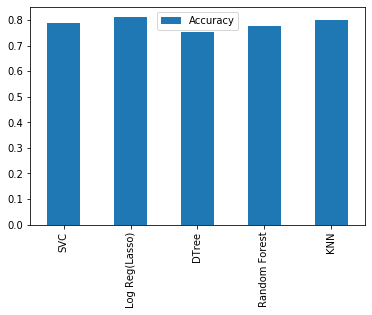

In [178]:
results_df.plot(kind = 'bar')

<h1>Making Predictions on the Test Set</h1>

In [182]:
submission_data_raw = pd.read_csv(r'C:\Users\ASUS\Desktop\Kaggle\Titanic Dataset\test (1).csv')
submission_data_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [183]:
submission_data_raw.drop(['PassengerId','Ticket'],axis = 1,inplace = True)
submission_data_raw.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,NaN,S


In [184]:
column_list = submission_data_raw.columns.tolist()
column_list[0] = "Ticket Class"
column_list[4] = "Number of Siblings/Spouses aboard"
column_list[5] = "Number of Parents/Children aboard"
submission_data_raw.columns = column_list
submission_data_raw.head()

,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,NaN,S


In [185]:
missing_data_df = numberofnan(submission_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Ticket Class,0,0
1,Name,0,0
2,Sex,0,0
3,Age,86,20.5742
4,Number of Siblings/Spouses aboard,0,0
5,Number of Parents/Children aboard,0,0
6,Fare,1,0.239234
7,Cabin,327,78.2297
8,Embarked,0,0


In [186]:
filldrop_submission = fillmissingvalues()
submission_data_raw = filldrop_submission.fit_transform(submission_data_raw)

In [187]:
submission_data_raw.head()

,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


In [188]:
missing_data_df = numberofnan(submission_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Ticket Class,0,0
1,Name,0,0
2,Sex,0,0
3,Age,0,0
4,Number of Siblings/Spouses aboard,0,0
5,Number of Parents/Children aboard,0,0
6,Fare,1,0.239234
7,Embarked,0,0


In [190]:
submission_data_raw['Fare'] = submission_data_raw['Fare'].fillna(submission_data_raw['Fare'].mean())

In [191]:
missing_data_df = numberofnan(submission_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Ticket Class,0,0
1,Name,0,0
2,Sex,0,0
3,Age,0,0
4,Number of Siblings/Spouses aboard,0,0
5,Number of Parents/Children aboard,0,0
6,Fare,0,0
7,Embarked,0,0


In [192]:
submission_data_raw.isna().sum()

Ticket Class                         0
Name                                 0
Sex                                  0
Age                                  0
Number of Siblings/Spouses aboard    0
Number of Parents/Children aboard    0
Fare                                 0
Embarked                             0
dtype: int64

In [193]:
#Add Family Size Attribute
famsize_submission = createfamilysize()
testing_data_raw = famsize_submission.fit_transform(submission_data_raw)
submission_data_raw.head()

,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size
0,3,"Kelly, Mr. James",male,34.5,7.8292,Q,1
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,7.0000,S,2
2,2,"Myles, Mr. Thomas Francis",male,62.0,9.6875,Q,1
3,3,"Wirz, Mr. Albert",male,27.0,8.6625,S,1
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,12.2875,S,3


In [194]:
#Add Port C Advantage
portCadvantage_submission = createportCadvantage()
submission_data_raw = portCadvantage_submission.fit_transform(submission_data_raw)
submission_data_raw.head()

,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,PortC_Advantage
0,3,"Kelly, Mr. James",male,34.5,7.8292,Q,1,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,7.0000,S,2,0
2,2,"Myles, Mr. Thomas Francis",male,62.0,9.6875,Q,1,0
3,3,"Wirz, Mr. Albert",male,27.0,8.6625,S,1,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,12.2875,S,3,0


In [195]:
#Create Title
title_submission = createTitle()
submission_data_raw = title_submission.fit_transform(submission_data_raw)
submission_data_raw.head()

,Ticket Class,Name,Sex,Age,Fare,Embarked,Family Size,PortC_Advantage,Title
0,3,"Kelly, Mr. James",male,34.5,7.8292,Q,1,0,Mr
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,7.0000,S,2,0,Mrs
2,2,"Myles, Mr. Thomas Francis",male,62.0,9.6875,Q,1,0,Mr
3,3,"Wirz, Mr. Albert",male,27.0,8.6625,S,1,0,Mr
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,12.2875,S,3,0,Mrs


In [196]:
#Create Title Advantage
titleadvantage_submission = createTitleAdvantage()
submission_data_raw = titleadvantage_submission.fit_transform(submission_data_raw)
submission_data_raw.head()

,Ticket Class,Sex,Age,Fare,Embarked,Family Size,PortC_Advantage,Title Advantage
0,3,male,34.5,7.8292,Q,1,0,Low
1,3,female,47.0,7.0000,S,2,0,High
2,2,male,62.0,9.6875,Q,1,0,Low
3,3,male,27.0,8.6625,S,1,0,Low
4,3,female,22.0,12.2875,S,3,0,High


In [197]:
num_attributes = ['Age','Fare','Family Size']
cat_attributes = ['Ticket Class','Sex','Embarked','PortC_Advantage','Title Advantage']
numerical_df_submission = num_pipeline.fit_transform(submission_data_raw)
categorical_df_submission = cat_pipeline.fit_transform(submission_data_raw)

In [198]:
numerical_df_submission.head()

,Age,Fare,Family Size
0,0.323046,-0.498407,-0.553443
1,1.313314,-0.513274,0.105643
2,2.501637,-0.465088,-0.553443
3,-0.271116,-0.483466,-0.553443
4,-0.667223,-0.418471,0.764728


In [199]:
categorical_df_submission.head()

,Ticket Class_1,Ticket Class_2,Ticket Class_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,PortC_Advantage_0,PortC_Advantage_1,Title Advantage_High,Title Advantage_Inconclusive,Title Advantage_Low
0,0,0,1,0,1,0,1,0,1,0,0,0,1
1,0,0,1,1,0,0,0,1,1,0,1,0,0
2,0,1,0,0,1,0,1,0,1,0,0,0,1
3,0,0,1,0,1,0,0,1,1,0,0,0,1
4,0,0,1,1,0,0,0,1,1,0,1,0,0


In [200]:
final_df_submission = pd.concat([numerical_df_submission,categorical_df_submission],axis =1 )
final_df_submission.head()

,Age,Fare,Family Size,Ticket Class_1,Ticket Class_2,Ticket Class_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,PortC_Advantage_0,PortC_Advantage_1,Title Advantage_High,Title Advantage_Inconclusive,Title Advantage_Low
0,0.323046,-0.498407,-0.553443,0,0,1,0,1,0,1,0,1,0,0,0,1
1,1.313314,-0.513274,0.105643,0,0,1,1,0,0,0,1,1,0,1,0,0
2,2.501637,-0.465088,-0.553443,0,1,0,0,1,0,1,0,1,0,0,0,1
3,-0.271116,-0.483466,-0.553443,0,0,1,0,1,0,0,1,1,0,0,0,1
4,-0.667223,-0.418471,0.764728,0,0,1,1,0,0,0,1,1,0,1,0,0


<h1>From the models that were investigated above, the model which gave the highest accuracy for the test set is the Logistic Regression with Lasso Regularization model. Hence this model is used to predict the submission dataset</h1>

In [201]:
submission_prediction = random_search_lr.best_estimator_.predict(final_df_submission)

In [202]:
submission_prediction

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [203]:
submission_prediction_df = pd.DataFrame({'PassengerID':pd.read_csv(r'C:\Users\ASUS\Desktop\Kaggle\Titanic Dataset\test (1).csv')['PassengerId'],'Prediction':submission_prediction})

In [205]:
submission_prediction_df.to_csv('Submission.csv')